In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import jieba
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')
np.random.seed(42)

In [2]:
category_dict = {
    '100': 'news_story',
    '101': 'news_culture',
    '102': 'news_entertainment',
    '103': 'news_sports',
    '104': 'news_finance',
    '106': 'news_house',
    '107': 'news_car',
    '108': 'news_edu',
    '109': 'news_tech',
    '110': 'news_military',
    '112': 'news_travel',
    '113': 'news_world',
    '114': 'stock',
    '115': 'news_agriculture',
    '116': 'news_game'
}

### 加载停用词表

In [ ]:
def load_stopwords(file_path='./data/stopwords.txt'):
    try:
        with open(file_path, 'r', encoding='utf-8') as f:
            stopwords = [line.strip() for line in f]
        return set(stopwords)
    except FileNotFoundError:
        print(f"警告: 停用词文件 {file_path} 不存在，将使用空停用词集合")
        return set()

### 文本预处理函数

In [ ]:
def preprocess_text(text, stopwords=None):
    if stopwords is None:
        stopwords = set()
        
    # 保留中文字符
    text = re.sub(r'[^\u4e00-\u9fa5]', ' ', text)
    
    # 分词
    words = jieba.cut(text)
    
    # 去停用词
    words = [word for word in words if word.strip() and word not in stopwords]
    
    return ' '.join(words)

### 加载数据

In [ ]:
def load_data(file_path, sample_size=None):
    print("正在加载数据...")
    
    # 读取数据
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    if sample_size and sample_size < len(lines):
        lines = np.random.choice(lines, sample_size, replace=False)
    
    data = []
    for line in lines:
        parts = line.strip().split('_!_')
        if len(parts) >= 5:
            news_id = parts[0]
            category_id = parts[1]
            category_name = parts[2]
            title = parts[3]
            keywords = parts[4] if len(parts) > 4 else ''
            
            data.append({
                'news_id': news_id,
                'category_id': category_id,
                'category_name': category_name,
                'title': title,
                'keywords': keywords
            })
    
    df = pd.DataFrame(data)
    print(f"加载完成，共 {len(df)} 条数据")
    return df

### Data Exploratory Analysis

In [ ]:
def explore_data(df):
    print("\nData Exploration:")
    print(f"Dataset size: {df.shape}")
    print("\nCategory Distribution:")
    category_counts = df['category_name'].value_counts()
    print(category_counts)
    
    # Visualize category distribution
    plt.figure(figsize=(12, 6))
    sns.barplot(x=category_counts.index, y=category_counts.values)
    plt.title('Category Distribution')
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Title length analysis
    df['title_length'] = df['title'].apply(len)
    print("\nTitle Length Statistics:")
    print(df['title_length'].describe())
    
    plt.figure(figsize=(12, 6))
    sns.histplot(df['title_length'], kde=True)
    plt.title('Title Length Distribution')
    plt.xlabel('Length')
    plt.ylabel('Frequency')
    plt.show()
    
    return category_counts

====== 今日头条新闻分类实验 ======
正在加载数据...
加载完成，共 382688 条数据

Data Exploration:
Dataset size: (382688, 5)

Category Distribution:
category_name
news_tech             41543
news_entertainment    39396
news_sports           37568
news_car              35785
news_game             29300
news_culture          28031
news_finance          27085
news_edu              27058
news_world            26909
news_military         24984
news_travel           21422
news_agriculture      19322
news_house            17672
news_story             6273
stock                   340
Name: count, dtype: int64


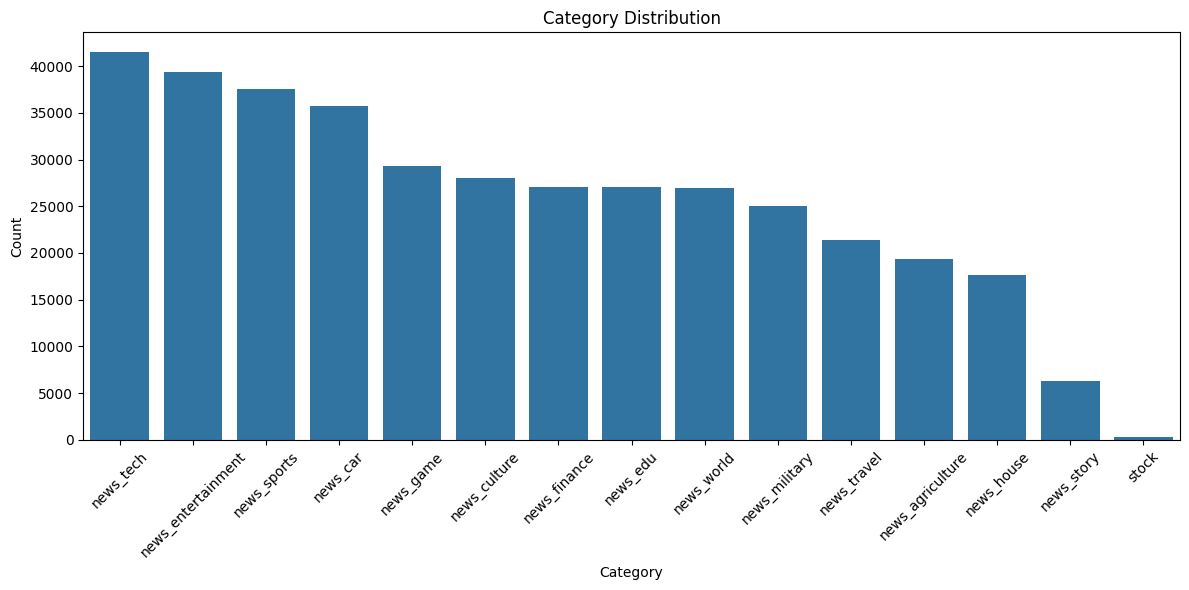


Title Length Statistics:
count    382688.000000
mean         22.812581
std           7.191947
min           2.000000
25%          17.000000
50%          23.000000
75%          28.000000
max         150.000000
Name: title_length, dtype: float64


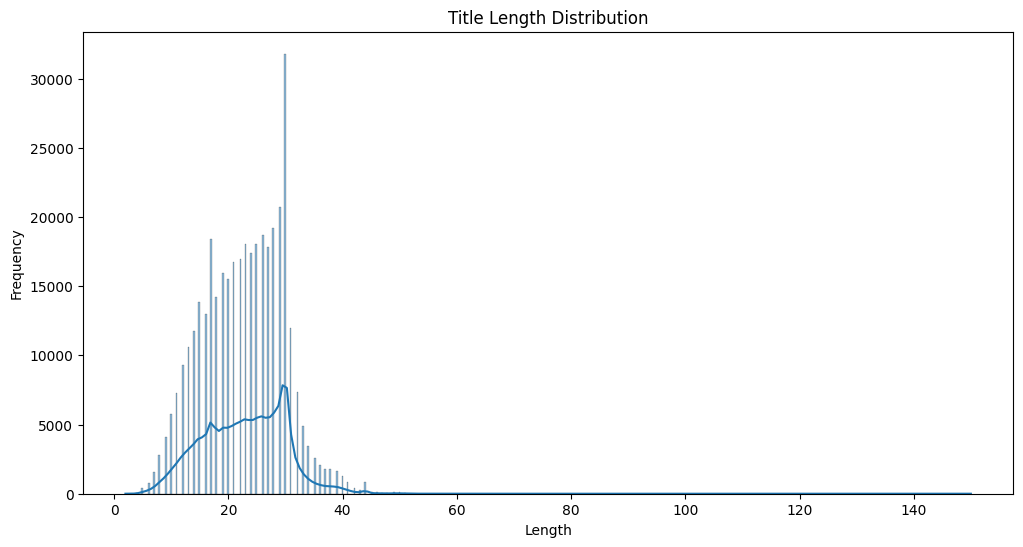

In [ ]:
print("====== 今日头条新闻分类实验 ======")
data_path = "./data/toutiao_cat_data.txt"

df = load_data(data_path)

category_counts = explore_data(df)

In [ ]:
stopwords = load_stopwords()

print("\n开始文本预处理...")
df['processed_title'] = df['title'].apply(lambda x: preprocess_text(x, stopwords))

print("\n预处理后的示例:")
for i in range(5):
    print(f"原始标题: {df['title'].iloc[i]}")
    print(f"预处理后: {df['processed_title'].iloc[i]}")
    print("-" * 50)

Building prefix dict from the default dictionary ...
Loading model from cache /var/folders/j8/mfdp3rfj6qz1xhlkc79_7qyw0000gn/T/jieba.cache



开始文本预处理...


Loading model cost 0.216 seconds.
Prefix dict has been built successfully.



预处理后的示例:
原始标题: 京城最值得你来场文化之旅的博物馆
预处理后: 京城 最 值得 来场 文化 之旅 博物馆
--------------------------------------------------
原始标题: 发酵床的垫料种类有哪些？哪种更好？
预处理后: 发酵 床 垫料 种类 有 哪些 哪 种 更好
--------------------------------------------------
原始标题: 上联：黄山黄河黄皮肤黄土高原。怎么对下联？
预处理后: 上联 黄山 黄河 黄皮肤 黄土高原 怎么 对 下联
--------------------------------------------------
原始标题: 林徽因什么理由拒绝了徐志摩而选择梁思成为终身伴侣？
预处理后: 林徽因 什么 理由 拒绝 徐志摩 选择 梁思成 为 终身伴侣
--------------------------------------------------
原始标题: 黄杨木是什么树？
预处理后: 黄杨木 什么 树
--------------------------------------------------


### 数据集划分

In [ ]:
print("\n划分训练集和测试集...")
X_train, X_test, y_train, y_test = train_test_split(
    df['processed_title'],
    df['category_name'],
    test_size=0.3,
    random_state=42,
    stratify=df['category_name']
)

print(f"训练集大小: {len(X_train)}")
print(f"测试集大小: {len(X_test)}")


划分训练集和测试集...
训练集大小: 267881
测试集大小: 114807


### 创建TF-IDF特征

In [ ]:
print("\n提取TF-IDF特征...")
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print(f"TF-IDF特征维度: {X_train_tfidf.shape}")

print(f"词汇表大小: {len(tfidf_vectorizer.vocabulary_)}")

features = tfidf_vectorizer.get_feature_names_out()
print(f"部分特征词汇: {features[:10]}")


提取TF-IDF特征...
TF-IDF特征维度: (267881, 10000)
词汇表大小: 10000
部分特征词汇: ['一万' '一万元' '一下' '一不小心' '一世' '一个亿' '一个月' '一中' '一事' '一些']


### MultinomialNB 模型训练与评估



训练 MultinomialNB 模型...

MultinomialNB 模型性能:
准确率: 0.7894
精确率: 0.7908
召回率: 0.7894
F1值: 0.7889


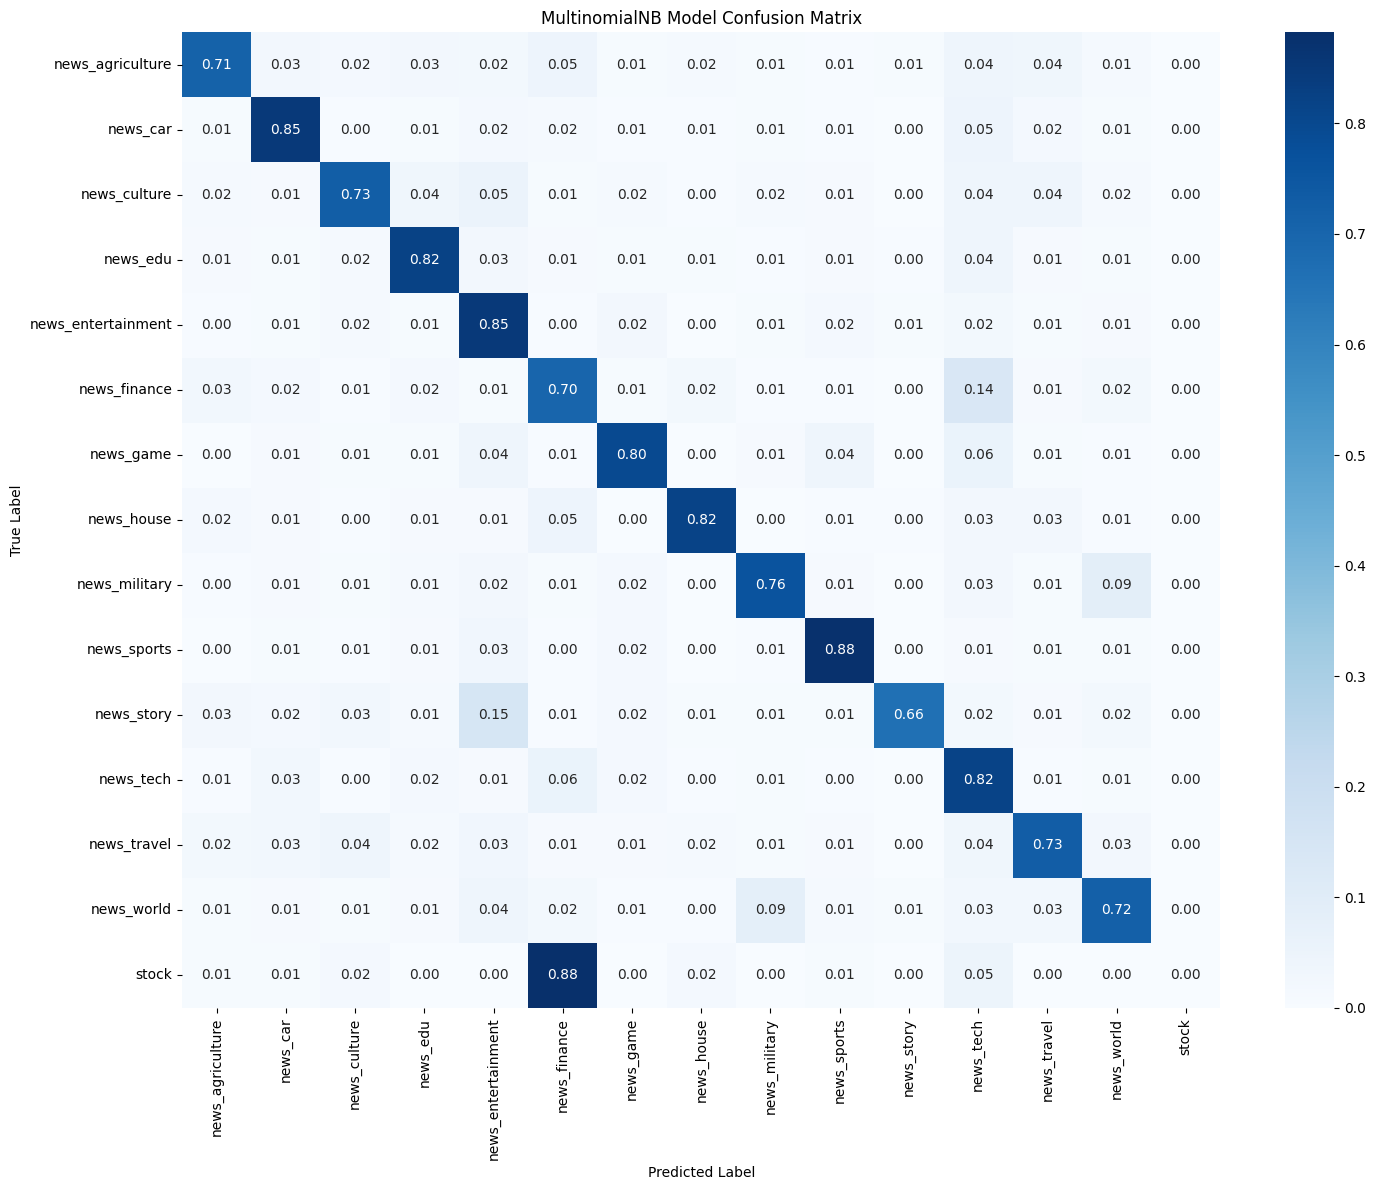


MultinomialNB 分类报告:
                    precision    recall  f1-score   support

  news_agriculture       0.79      0.71      0.75      5797
          news_car       0.85      0.85      0.85     10736
      news_culture       0.83      0.73      0.78      8409
          news_edu       0.80      0.82      0.81      8117
news_entertainment       0.77      0.85      0.81     11819
      news_finance       0.73      0.70      0.72      8125
         news_game       0.83      0.80      0.81      8790
        news_house       0.86      0.82      0.84      5302
     news_military       0.79      0.76      0.78      7495
       news_sports       0.88      0.88      0.88     11270
        news_story       0.76      0.66      0.71      1882
         news_tech       0.70      0.82      0.76     12463
       news_travel       0.73      0.73      0.73      6427
        news_world       0.75      0.72      0.74      8073
             stock       0.00      0.00      0.00       102

          accurac

In [ ]:
print("\n训练 MultinomialNB 模型...")
mnb = MultinomialNB(alpha=0.001)
mnb.fit(X_train_tfidf, y_train)

y_pred_mnb = mnb.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_mnb)
precision = precision_score(y_test, y_pred_mnb, average='weighted')
recall = recall_score(y_test, y_pred_mnb, average='weighted')
f1 = f1_score(y_test, y_pred_mnb, average='weighted')

print("\nMultinomialNB 模型性能:")
print(f"准确率: {accuracy:.4f}")
print(f"精确率: {precision:.4f}")
print(f"召回率: {recall:.4f}")
print(f"F1值: {f1:.4f}")

plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred_mnb)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2f', 
    cmap='Blues',
    xticklabels=sorted(y_test.unique()),
    yticklabels=sorted(y_test.unique())
)
plt.title('MultinomialNB Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

report = classification_report(y_test, y_pred_mnb)
print("\nMultinomialNB 分类报告:")
print(report)

### ComplementNB 模型训练与评估


训练 ComplementNB 模型...

ComplementNB 模型性能:
准确率: 0.7947
精确率: 0.7932
召回率: 0.7947
F1值: 0.7933


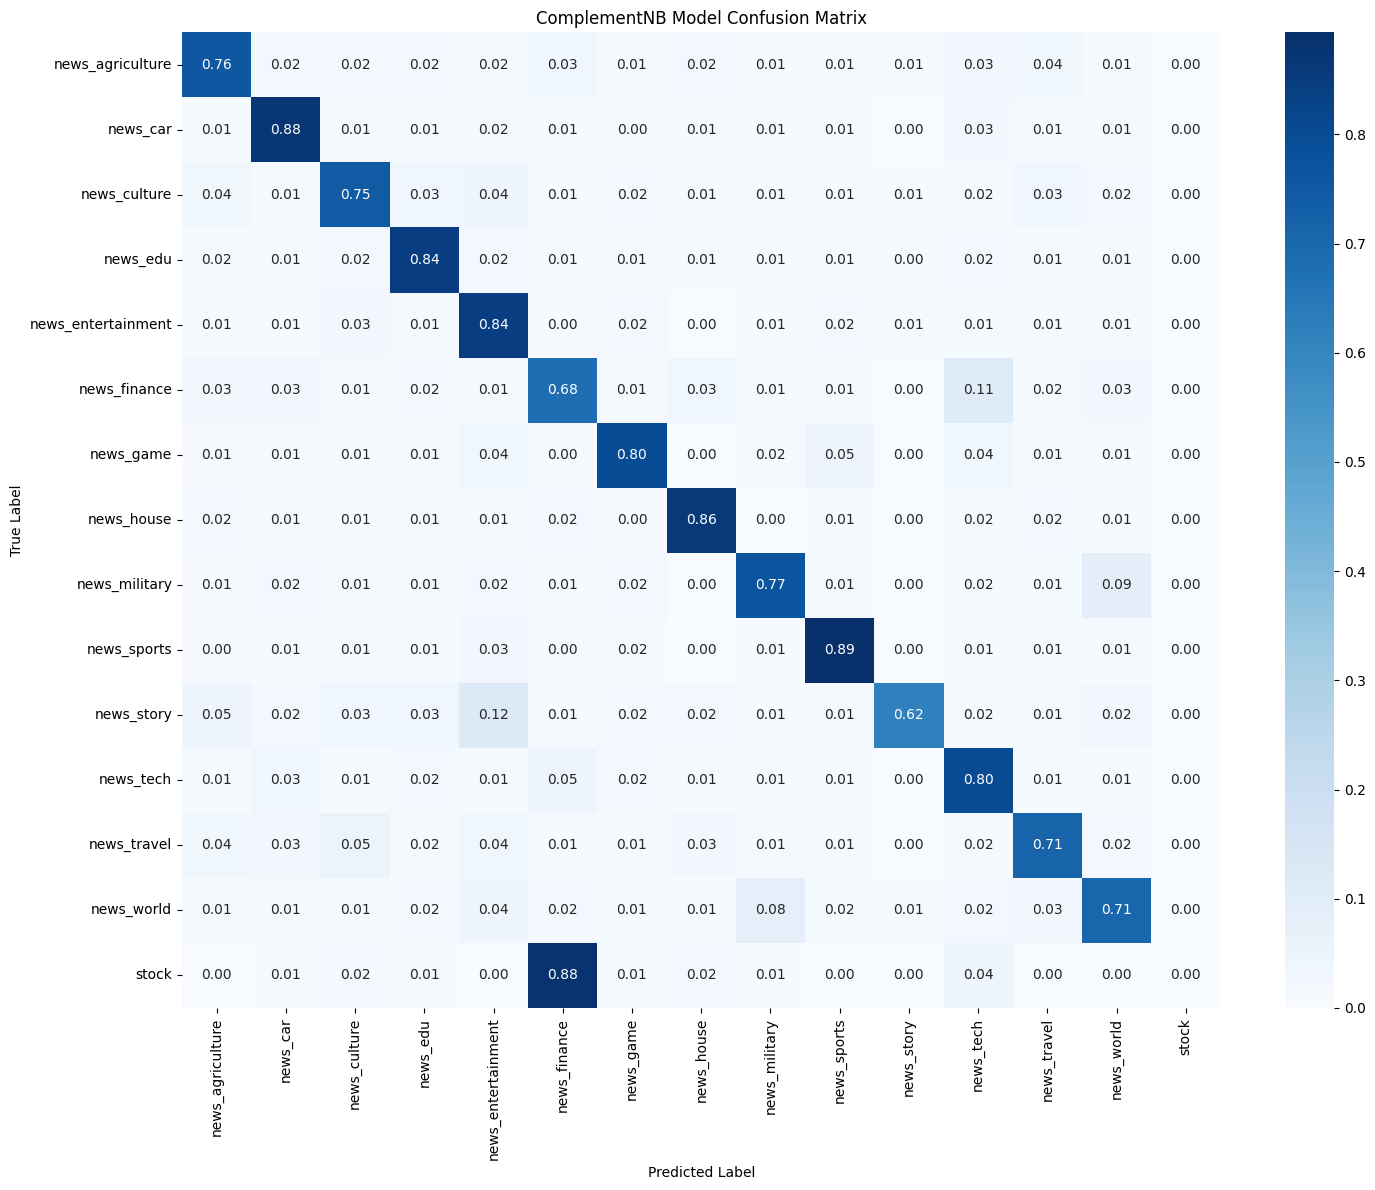


ComplementNB 分类报告:
                    precision    recall  f1-score   support

  news_agriculture       0.73      0.76      0.74      5797
          news_car       0.84      0.88      0.86     10736
      news_culture       0.80      0.75      0.77      8409
          news_edu       0.80      0.84      0.82      8117
news_entertainment       0.79      0.84      0.81     11819
      news_finance       0.77      0.68      0.72      8125
         news_game       0.82      0.80      0.81      8790
        news_house       0.81      0.86      0.83      5302
     news_military       0.79      0.77      0.78      7495
       news_sports       0.87      0.89      0.88     11270
        news_story       0.70      0.62      0.66      1882
         news_tech       0.78      0.80      0.79     12463
       news_travel       0.73      0.71      0.72      6427
        news_world       0.75      0.71      0.73      8073
             stock       0.00      0.00      0.00       102

          accuracy

In [ ]:
print("\n训练 ComplementNB 模型...")
cnb = ComplementNB(alpha=0.001)
cnb.fit(X_train_tfidf, y_train)

y_pred_cnb = cnb.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred_cnb)
precision = precision_score(y_test, y_pred_cnb, average='weighted')
recall = recall_score(y_test, y_pred_cnb, average='weighted')
f1 = f1_score(y_test, y_pred_cnb, average='weighted')

print("\nComplementNB 模型性能:")
print(f"准确率: {accuracy:.4f}")
print(f"精确率: {precision:.4f}")
print(f"召回率: {recall:.4f}")
print(f"F1值: {f1:.4f}")

plt.figure(figsize=(15, 12))
cm = confusion_matrix(y_test, y_pred_cnb)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

sns.heatmap(
    cm_normalized, 
    annot=True, 
    fmt='.2f', 
    cmap='Blues',
    xticklabels=sorted(y_test.unique()),
    yticklabels=sorted(y_test.unique())
)
plt.title('ComplementNB Model Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

report = classification_report(y_test, y_pred_cnb)
print("\nComplementNB 分类报告:")
print(report)

### 比较不同模型性能

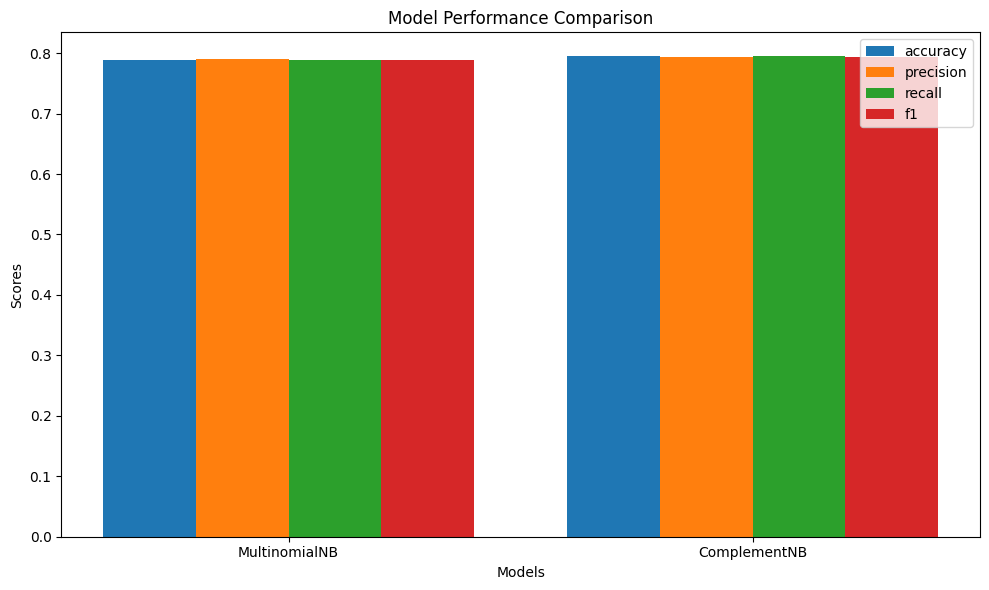


模型性能比较:

MultinomialNB:
accuracy: 0.7894
precision: 0.7908
recall: 0.7894
f1: 0.7889

ComplementNB:
accuracy: 0.7947
precision: 0.7932
recall: 0.7947
f1: 0.7933


In [ ]:
results = {
    "MultinomialNB": {
        'accuracy': accuracy_score(y_test, y_pred_mnb),
        'precision': precision_score(y_test, y_pred_mnb, average='weighted'),
        'recall': recall_score(y_test, y_pred_mnb, average='weighted'),
        'f1': f1_score(y_test, y_pred_mnb, average='weighted')
    },
    "ComplementNB": {
        'accuracy': accuracy_score(y_test, y_pred_cnb),
        'precision': precision_score(y_test, y_pred_cnb, average='weighted'),
        'recall': recall_score(y_test, y_pred_cnb, average='weighted'),
        'f1': f1_score(y_test, y_pred_cnb, average='weighted')
    }
}

plt.figure(figsize=(10, 6))
metrics = ['accuracy', 'precision', 'recall', 'f1']

for i, metric in enumerate(metrics):
    values = [results[model][metric] for model in results]
    plt.bar([x + i*0.2 for x in range(len(results))], values, width=0.2, label=metric)

plt.xlabel('Models')
plt.ylabel('Scores')
plt.title('Model Performance Comparison')
plt.xticks([i + 0.3 for i in range(len(results))], list(results.keys()))
plt.legend()
plt.tight_layout()
plt.show()

print("\n模型性能比较:")
for model in results:
    print(f"\n{model}:")
    for metric, value in results[model].items():
        print(f"{metric}: {value:.4f}")

### 错误分析

In [ ]:
print("\n对错误预测进行分析...")

errors_mnb = []
for i, (true, pred) in enumerate(zip(y_test, y_pred_mnb)):
    if true != pred:
        errors_mnb.append({
            'index': i,
            'title': X_test.iloc[i],
            'true': true,
            'pred': pred
        })

errors_cnb = []
for i, (true, pred) in enumerate(zip(y_test, y_pred_cnb)):
    if true != pred:
        errors_cnb.append({
            'index': i,
            'title': X_test.iloc[i],
            'true': true,
            'pred': pred
        })

print(f"MultinomialNB 错误数: {len(errors_mnb)}")
print(f"ComplementNB 错误数: {len(errors_cnb)}")

print("\n部分 MultinomialNB 错误案例:")
for error in errors_mnb[:5]:
    print(f"标题: {error['title']}")
    print(f"真实类别: {error['true']}")
    print(f"预测类别: {error['pred']}")
    print("-" * 50)


对错误预测进行分析...
MultinomialNB 错误数: 24177
ComplementNB 错误数: 23575

部分 MultinomialNB 错误案例:
标题: 俄罗斯 一 武装 直升机 在 叙利亚 坠毁
真实类别: news_world
预测类别: news_military
--------------------------------------------------
标题: 区块 链 一杯 带 泡沫 啤酒 究竟 风口 还是 骗局
真实类别: news_tech
预测类别: news_finance
--------------------------------------------------
标题: 绝味 食品 每年 消耗 亿只 鸭子 华中 区 啃 鸭 脖 最 厉害
真实类别: news_finance
预测类别: news_military
--------------------------------------------------
标题: 如果 俄罗斯 军事 扶植 巴沙尔 叙利亚 局势 会 怎样
真实类别: news_military
预测类别: news_world
--------------------------------------------------
标题: 里 到底 担任 什么样 角色
真实类别: news_game
预测类别: news_entertainment
--------------------------------------------------


### 分析类别混淆情况

In [ ]:
print("\n类别混淆情况分析:")

def analyze_confusion(y_true, y_pred):
    confusion = {}
    for true, pred in zip(y_true, y_pred):
        if true != pred:
            if true not in confusion:
                confusion[true] = {}
            if pred not in confusion[true]:
                confusion[true][pred] = 0
            confusion[true][pred] += 1
    return confusion

mnb_confusion = analyze_confusion(y_test, y_pred_mnb)
cnb_confusion = analyze_confusion(y_test, y_pred_cnb)

print("\nMultinomialNB 混淆情况:")
for true_class, preds in mnb_confusion.items():
    print(f"\n真实类别: {true_class}")
    for pred_class, count in sorted(preds.items(), key=lambda x: x[1], reverse=True)[:3]:
        print(f"  误分为 {pred_class}: {count} 次")


类别混淆情况分析:

MultinomialNB 混淆情况:

真实类别: news_world
  误分为 news_military: 692 次
  误分为 news_entertainment: 325 次
  误分为 news_tech: 234 次

真实类别: news_tech
  误分为 news_finance: 697 次
  误分为 news_car: 366 次
  误分为 news_game: 251 次

真实类别: news_finance
  误分为 news_tech: 1102 次
  误分为 news_agriculture: 229 次
  误分为 news_house: 187 次

真实类别: news_military
  误分为 news_world: 678 次
  误分为 news_tech: 201 次
  误分为 news_entertainment: 186 次

真实类别: news_game
  误分为 news_tech: 495 次
  误分为 news_sports: 367 次
  误分为 news_entertainment: 358 次

真实类别: news_culture
  误分为 news_entertainment: 436 次
  误分为 news_travel: 343 次
  误分为 news_tech: 341 次

真实类别: news_edu
  误分为 news_tech: 341 次
  误分为 news_entertainment: 212 次
  误分为 news_culture: 135 次

真实类别: news_car
  误分为 news_tech: 512 次
  误分为 news_entertainment: 198 次
  误分为 news_travel: 187 次

真实类别: news_sports
  误分为 news_entertainment: 374 次
  误分为 news_game: 207 次
  误分为 news_tech: 151 次

真实类别: news_entertainment
  误分为 news_game: 288 次
  误分为 news_tech: 270 次
  误分为 news_sports: 219 

### Word2Vec 实验

In [ ]:
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier

def train_word2vec(processed_texts, vector_size=100, window=5, min_count=1):
    """训练Word2Vec模型"""
    sentences = [text.split() for text in processed_texts]
    
    model = Word2Vec(sentences, vector_size=vector_size, window=window, 
                     min_count=min_count, workers=4)
    
    return model

def text_to_vector(text, model, vector_size=100):
    """将文本转换为向量表示"""
    words = text.split()
    word_vectors = [model.wv[word] for word in words if word in model.wv]
    
    if len(word_vectors) == 0:
        return np.zeros(vector_size)
    
    text_vector = np.mean(word_vectors, axis=0)
    return text_vector

print("\n开始Word2Vec文本分类实验...")

vector_size = 100
print("\n训练Word2Vec模型...")
word2vec_model = train_word2vec(X_train, vector_size=vector_size)

print("\n转换文本为词向量...")
X_train_vec = np.array([text_to_vector(text, word2vec_model, vector_size) for text in X_train])
X_test_vec = np.array([text_to_vector(text, word2vec_model, vector_size) for text in X_test])

print("\n训练随机森林分类器...")
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_vec, y_train)

print("\n预测并评估模型...")
y_pred = clf.predict(X_test_vec)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Word2Vec + RandomForest 准确率: {accuracy:.4f}")
print("\n分类报告:")
print(report)


开始Word2Vec文本分类实验...

训练Word2Vec模型...

转换文本为词向量...

训练随机森林分类器...

预测并评估模型...
Word2Vec + RandomForest 准确率: 0.7498

分类报告:
                    precision    recall  f1-score   support

  news_agriculture       0.73      0.61      0.67      5797
          news_car       0.76      0.81      0.78     10736
      news_culture       0.79      0.72      0.75      8409
          news_edu       0.78      0.80      0.79      8117
news_entertainment       0.65      0.82      0.72     11819
      news_finance       0.67      0.66      0.66      8125
         news_game       0.82      0.75      0.78      8790
        news_house       0.84      0.73      0.78      5302
     news_military       0.76      0.71      0.73      7495
       news_sports       0.83      0.81      0.82     11270
        news_story       0.74      0.55      0.63      1882
         news_tech       0.74      0.81      0.77     12463
       news_travel       0.70      0.70      0.70      6427
        news_world       0.77      0.71

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import time
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

if torch.backends.mps.is_available():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(f"Using device: {device}")

Using device: mps


### 定义文本数据集类

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=50):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        
        tokens = text.split()
        encoded = [self.vocab.get(token, 0) for token in tokens]  # 0 为 <UNK>
        
        if len(encoded) > self.max_len:
            encoded = encoded[:self.max_len]
        else:
            encoded = encoded + [0] * (self.max_len - len(encoded))  # 0 为 <PAD>
        
        return {
            'text': torch.tensor(encoded, dtype=torch.long),
            'label': torch.tensor(label, dtype=torch.long)
        }

def build_vocab(texts, max_vocab_size=10000):
    print("构建词汇表...")
    word_count = {}
    
    for text in texts:
        for word in text.split():
            if word not in word_count:
                word_count[word] = 0
            word_count[word] += 1
    
    sorted_vocab = sorted(word_count.items(), key=lambda x: x[1], reverse=True)
    
    vocab = {}
    vocab['<PAD>'] = 0  # 填充标记
    vocab['<UNK>'] = 1  # 未知词标记
    
    for i, (word, _) in enumerate(sorted_vocab[:max_vocab_size-2]):
        vocab[word] = i + 2
    
    print(f"词汇表大小: {len(vocab)}")
    return vocab

### TextCNN 模型

In [ ]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_classes, filter_sizes, num_filters, dropout):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.convs = nn.ModuleList([
            nn.Conv2d(1, num_filters, (filter_size, embedding_dim)) 
            for filter_size in filter_sizes
        ])
        
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
    
    def forward(self, x):
        # x: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        embedded = embedded.unsqueeze(1)  # (batch_size, 1, seq_len, embedding_dim)
        
        conved = [nn.functional.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conved[i]: (batch_size, num_filters, seq_len - filter_sizes[i] + 1)
        
        pooled = [nn.functional.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled[i]: (batch_size, num_filters)
        
        cat = torch.cat(pooled, dim=1)  # (batch_size, num_filters * len(filter_sizes))
        
        dropped = self.dropout(cat)
        logits = self.fc(dropped)
        
        return logits

### Bi-LSTM 模型

In [ ]:
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, dropout):
        super(BiLSTMModel, self).__init__()
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(
            embedding_dim, 
            hidden_dim, 
            bidirectional=True,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # 双向LSTM
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        # x: (batch_size, seq_len)
        
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)
        
        # LSTM
        outputs, (hidden, cell) = self.lstm(embedded)
        # outputs: (batch_size, seq_len, hidden_dim * 2)
        # hidden: (2, batch_size, hidden_dim)
        
        # 拼接最后一个时间步的前向和后向隐藏状态
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)  # (batch_size, hidden_dim * 2)
        
        # Dropout和全连接
        dropped = self.dropout(hidden)
        logits = self.fc(dropped)
        
        return logits

In [ ]:
from tqdm.notebook import tqdm

def train_model(model, train_loader, valid_loader, optimizer, criterion, device, model_name, epochs=5):
    model.to(device)
    
    history = {
        'train_loss': [],
        'train_acc': [],
        'valid_loss': [],
        'valid_acc': []
    }
    
    best_valid_loss = float('inf')
    
    for epoch in range(epochs):
        start_time = time.time()
        
        model.train()
        epoch_loss = 0
        epoch_correct = 0
        epoch_total = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} [Train]', 
                          leave=True, ncols=100)
        
        for batch in train_pbar:
            text = batch['text'].to(device)
            label = batch['label'].to(device)
            
            optimizer.zero_grad()
            logits = model(text)
            loss = criterion(logits, label)
            
            loss.backward()
            optimizer.step()
            
            preds = torch.argmax(logits, dim=1)
            correct = (preds == label).sum().item()
            
            epoch_loss += loss.item() * len(label)
            epoch_correct += correct
            epoch_total += len(label)
            
            current_loss = loss.item()
            current_acc = correct / len(label)
            train_pbar.set_postfix(loss=f'{current_loss:.4f}', acc=f'{current_acc:.4f}')
        
        train_loss = epoch_loss / epoch_total
        train_acc = epoch_correct / epoch_total
        
        model.eval()
        valid_loss = 0
        valid_correct = 0
        valid_total = 0
        
        valid_pbar = tqdm(valid_loader, desc=f'Epoch {epoch+1}/{epochs} [Valid]', 
                          leave=True, ncols=100)
        
        with torch.no_grad():
            for batch in valid_pbar:
                text = batch['text'].to(device)
                label = batch['label'].to(device)
                
                # 前向传播
                logits = model(text)
                loss = criterion(logits, label)
                
                # 计算准确率
                preds = torch.argmax(logits, dim=1)
                correct = (preds == label).sum().item()
                
                valid_loss += loss.item() * len(label)
                valid_correct += correct
                valid_total += len(label)
                
                current_loss = loss.item()
                current_acc = correct / len(label)
                valid_pbar.set_postfix(loss=f'{current_loss:.4f}', acc=f'{current_acc:.4f}')
        
        valid_loss = valid_loss / valid_total
        valid_acc = valid_correct / valid_total
        
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)
        
        epoch_model_path = f'./model/{model_name}_epoch_{epoch+1}.pt'
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'valid_loss': valid_loss,
            'train_acc': train_acc,
            'valid_acc': valid_acc,
        }, epoch_model_path)
        
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            best_model_path = f'{model_name}_best_model.pt'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'train_acc': train_acc,
                'valid_acc': valid_acc,
            }, best_model_path)
            best_flag = " (最佳模型)"
        else:
            best_flag = ""
        
        epoch_time = time.time() - start_time
        print(f'\nEpoch {epoch+1}/{epochs} | Time: {epoch_time:.2f}s{best_flag}')
        print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'Valid Loss: {valid_loss:.4f} | Valid Acc: {valid_acc:.4f}')
        print('-' * 60)
    
    return history

def evaluate_model(model, test_loader, criterion, device, classes):
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            text = batch['text'].to(device)
            label = batch['label'].to(device)
            
            logits = model(text)
            loss = criterion(logits, label)
            
            preds = torch.argmax(logits, dim=1)
            correct = (preds == label).sum().item()
            
            test_loss += loss.item() * len(label)
            test_correct += correct
            test_total += len(label)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(label.cpu().numpy())
    
    test_loss = test_loss / test_total
    test_acc = test_correct / test_total
    
    report = classification_report(all_labels, all_preds, target_names=classes)
    
    return test_loss, test_acc, report

In [ ]:
print("\n====== 神经网络文本分类实验 ======")

sample_size = 400000
if len(df) > sample_size:
    print(f"使用 {sample_size} 条样本进行神经网络实验")
    df_sample = df.sample(sample_size, random_state=42)
else:
    print(f"使用全部 {len(df)} 条样本进行神经网络实验")
    df_sample = df

label_encoder = LabelEncoder()
encoded_labels = label_encoder.fit_transform(df_sample['category_name'])
classes = label_encoder.classes_
print(f"类别数量: {len(classes)}")

vocab = build_vocab(df_sample['processed_title'], max_vocab_size=10000)

X_train, X_temp, y_train, y_temp = train_test_split(
    df_sample['processed_title'].values,
    encoded_labels,
    test_size=0.3,
    random_state=42,
    stratify=encoded_labels
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  # 15% 测试, 15% 验证
    random_state=42,
    stratify=y_temp
)

print(f"训练集大小: {len(X_train)}")
print(f"验证集大小: {len(X_valid)}")
print(f"测试集大小: {len(X_test)}")

max_len = 50

train_dataset = TextDataset(X_train, y_train, vocab, max_len)
valid_dataset = TextDataset(X_valid, y_valid, vocab, max_len)
test_dataset = TextDataset(X_test, y_test, vocab, max_len)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


====== 神经网络文本分类实验 ======
使用全部 382688 条样本进行神经网络实验
类别数量: 15
构建词汇表...
词汇表大小: 10000
训练集大小: 267881
验证集大小: 57403
测试集大小: 57404


### TextCNN 模型训练


====== 训练 TextCNN 模型 ======
开始训练TextCNN模型...


Epoch 1/5 [Train]:   0%|                                                   | 0/4186 [00:00<?, ?it/s]

Epoch 1/5 [Valid]:   0%|                                                    | 0/897 [00:00<?, ?it/s]


Epoch 1/5 | Time: 274.82s (最佳模型)
Train Loss: 1.3317 | Train Acc: 0.5976
Valid Loss: 0.8189 | Valid Acc: 0.7655
------------------------------------------------------------


Epoch 2/5 [Train]:   0%|                                                   | 0/4186 [00:00<?, ?it/s]

Epoch 2/5 [Valid]:   0%|                                                    | 0/897 [00:00<?, ?it/s]


Epoch 2/5 | Time: 269.59s (最佳模型)
Train Loss: 0.7876 | Train Acc: 0.7728
Valid Loss: 0.6973 | Valid Acc: 0.8036
------------------------------------------------------------


Epoch 3/5 [Train]:   0%|                                                   | 0/4186 [00:00<?, ?it/s]

Epoch 3/5 [Valid]:   0%|                                                    | 0/897 [00:00<?, ?it/s]


Epoch 3/5 | Time: 268.58s (最佳模型)
Train Loss: 0.6743 | Train Acc: 0.8068
Valid Loss: 0.6559 | Valid Acc: 0.8171
------------------------------------------------------------


Epoch 4/5 [Train]:   0%|                                                   | 0/4186 [00:00<?, ?it/s]

Epoch 4/5 [Valid]:   0%|                                                    | 0/897 [00:00<?, ?it/s]


Epoch 4/5 | Time: 269.54s (最佳模型)
Train Loss: 0.6220 | Train Acc: 0.8215
Valid Loss: 0.6514 | Valid Acc: 0.8180
------------------------------------------------------------


Epoch 5/5 [Train]:   0%|                                                   | 0/4186 [00:00<?, ?it/s]

Epoch 5/5 [Valid]:   0%|                                                    | 0/897 [00:00<?, ?it/s]


Epoch 5/5 | Time: 273.59s (最佳模型)
Train Loss: 0.5818 | Train Acc: 0.8318
Valid Loss: 0.6491 | Valid Acc: 0.8234
------------------------------------------------------------

在测试集上评估TextCNN模型...
测试损失: 0.6426 | 测试准确率: 0.8241

分类报告:
                    precision    recall  f1-score   support

  news_agriculture       0.82      0.77      0.79      2898
          news_car       0.91      0.86      0.89      5368
      news_culture       0.71      0.82      0.76      4205
          news_edu       0.85      0.85      0.85      4059
news_entertainment       0.82      0.86      0.84      5910
      news_finance       0.75      0.75      0.75      4063
         news_game       0.90      0.82      0.86      4395
        news_house       0.88      0.88      0.88      2651
     news_military       0.85      0.78      0.81      3747
       news_sports       0.94      0.88      0.91      5635
        news_story       0.72      0.71      0.72       941
         news_tech       0.80      0.84      0.82

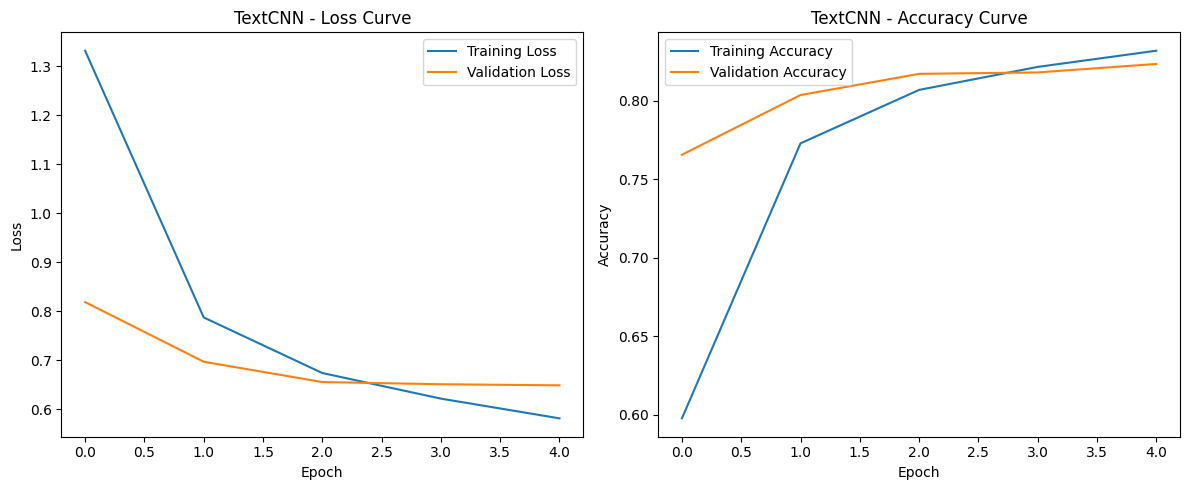

In [35]:
print("\n====== 训练 TextCNN 模型 ======")

vocab_size = len(vocab)
embedding_dim = 100
num_classes = len(classes)
filter_sizes = [3, 4, 5]
num_filters = 128
dropout = 0.5

cnn_model = TextCNN(vocab_size, embedding_dim, num_classes, filter_sizes, num_filters, dropout)

optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("开始训练TextCNN模型...")
cnn_history = train_model(
    cnn_model, 
    train_loader, 
    valid_loader, 
    optimizer, 
    criterion, 
    device,
    model_name='textcnn',
    epochs=5
)

print("\n在测试集上评估TextCNN模型...")
cnn_test_loss, cnn_test_acc, cnn_report = evaluate_model(cnn_model, test_loader, criterion, device, classes)
print(f"测试损失: {cnn_test_loss:.4f} | 测试准确率: {cnn_test_acc:.4f}")
print("\n分类报告:")
print(cnn_report)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(cnn_history['train_loss'], label='Training Loss')
plt.plot(cnn_history['valid_loss'], label='Validation Loss')
plt.title('TextCNN - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(cnn_history['train_acc'], label='Training Accuracy')
plt.plot(cnn_history['valid_acc'], label='Validation Accuracy')
plt.title('TextCNN - Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Bi-LSTM 模型训练


====== 训练 Bi-LSTM 模型 ======
开始训练Bi-LSTM模型...


Epoch 1/5 [Train]:   0%|                                                   | 0/4186 [00:00<?, ?it/s]

Epoch 1/5 [Valid]:   0%|                                                    | 0/897 [00:00<?, ?it/s]


Epoch 1/5 | Time: 45.52s (最佳模型)
Train Loss: 1.1661 | Train Acc: 0.6515
Valid Loss: 0.7644 | Valid Acc: 0.7796
------------------------------------------------------------


Epoch 2/5 [Train]:   0%|                                                   | 0/4186 [00:00<?, ?it/s]

Epoch 2/5 [Valid]:   0%|                                                    | 0/897 [00:00<?, ?it/s]


Epoch 2/5 | Time: 44.22s (最佳模型)
Train Loss: 0.7021 | Train Acc: 0.7995
Valid Loss: 0.6633 | Valid Acc: 0.8106
------------------------------------------------------------


Epoch 3/5 [Train]:   0%|                                                   | 0/4186 [00:00<?, ?it/s]

Epoch 3/5 [Valid]:   0%|                                                    | 0/897 [00:00<?, ?it/s]


Epoch 3/5 | Time: 44.06s (最佳模型)
Train Loss: 0.6004 | Train Acc: 0.8283
Valid Loss: 0.6332 | Valid Acc: 0.8191
------------------------------------------------------------


Epoch 4/5 [Train]:   0%|                                                   | 0/4186 [00:00<?, ?it/s]

Epoch 4/5 [Valid]:   0%|                                                    | 0/897 [00:00<?, ?it/s]


Epoch 4/5 | Time: 44.34s (最佳模型)
Train Loss: 0.5402 | Train Acc: 0.8447
Valid Loss: 0.6156 | Valid Acc: 0.8247
------------------------------------------------------------


Epoch 5/5 [Train]:   0%|                                                   | 0/4186 [00:00<?, ?it/s]

Epoch 5/5 [Valid]:   0%|                                                    | 0/897 [00:00<?, ?it/s]


Epoch 5/5 | Time: 43.63s
Train Loss: 0.4951 | Train Acc: 0.8570
Valid Loss: 0.6159 | Valid Acc: 0.8274
------------------------------------------------------------

在测试集上评估Bi-LSTM模型...
测试损失: 0.6023 | 测试准确率: 0.8304

分类报告:
                    precision    recall  f1-score   support

  news_agriculture       0.82      0.78      0.80      2898
          news_car       0.90      0.88      0.89      5368
      news_culture       0.73      0.83      0.78      4205
          news_edu       0.83      0.87      0.85      4059
news_entertainment       0.84      0.84      0.84      5910
      news_finance       0.78      0.72      0.75      4063
         news_game       0.86      0.86      0.86      4395
        news_house       0.89      0.87      0.88      2651
     news_military       0.85      0.81      0.83      3747
       news_sports       0.90      0.90      0.90      5635
        news_story       0.74      0.71      0.73       941
         news_tech       0.82      0.85      0.84      62

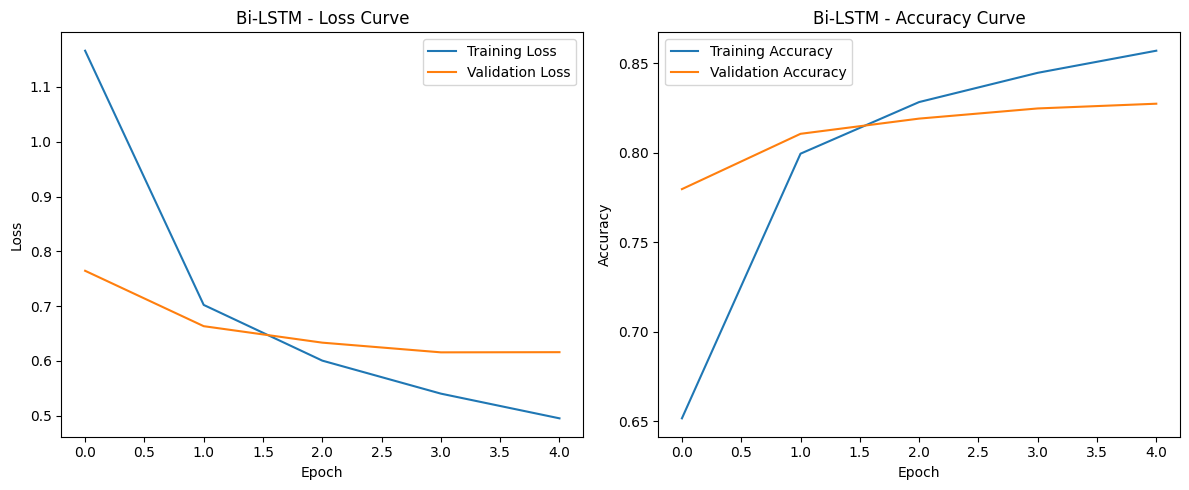

In [ ]:
print("\n====== 训练 Bi-LSTM 模型 ======")

vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 128
num_classes = len(classes)
dropout = 0.5

lstm_model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, num_classes, dropout)

optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("开始训练Bi-LSTM模型...")
lstm_history = train_model(
    lstm_model, 
    train_loader, 
    valid_loader, 
    optimizer, 
    criterion, 
    device,
    model_name='bilstm',
    epochs=5
)

print("\n在测试集上评估Bi-LSTM模型...")
lstm_test_loss, lstm_test_acc, lstm_report = evaluate_model(lstm_model, test_loader, criterion, device, classes)
print(f"测试损失: {lstm_test_loss:.4f} | 测试准确率: {lstm_test_acc:.4f}")
print("\n分类报告:")
print(lstm_report)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(lstm_history['train_loss'], label='Training Loss') 
plt.plot(lstm_history['valid_loss'], label='Validation Loss')
plt.title('Bi-LSTM - Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss') 
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(lstm_history['train_acc'], label='Training Accuracy')
plt.plot(lstm_history['valid_acc'], label='Validation Accuracy') 
plt.title('Bi-LSTM - Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


====== 模型性能比较 ======


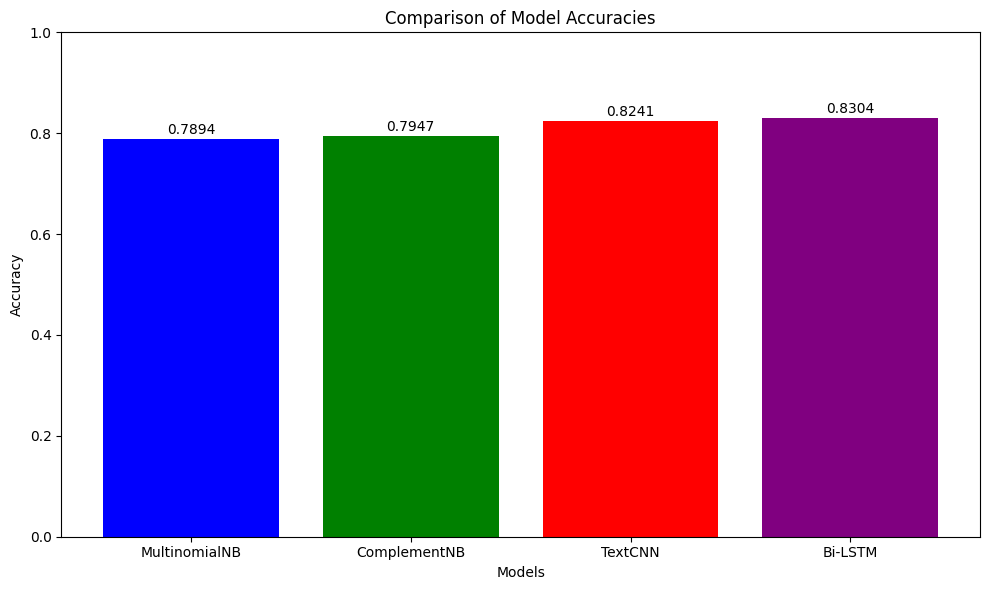

模型准确率比较:
MultinomialNB: 0.7894
ComplementNB: 0.7947
TextCNN: 0.8241
Bi-LSTM: 0.8304


In [36]:
print("\n====== 模型性能比较 ======")

model_accuracies = {
    'MultinomialNB': results['MultinomialNB']['accuracy'],
    'ComplementNB': results['ComplementNB']['accuracy'],
    'TextCNN': cnn_test_acc,
    'Bi-LSTM': lstm_test_acc
}

plt.figure(figsize=(10, 6))
models = list(model_accuracies.keys())
accuracies = list(model_accuracies.values())

plt.bar(models, accuracies, color=['blue', 'green', 'red', 'purple'])
plt.title('Comparison of Model Accuracies')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.01, f'{v:.4f}', ha='center')

plt.tight_layout()
plt.show()

print("模型准确率比较:")
for model, acc in model_accuracies.items():
    print(f"{model}: {acc:.4f}")

### 使用训练好的模型进行预测

In [ ]:
def predict_category(text, model, vocab, label_encoder, max_len=50, device='cpu'):
    text = preprocess_text(text, stopwords)
    
    tokens = text.split()
    encoded = [vocab.get(token, 1) for token in tokens]  # 1 为 <UNK>
    
    if len(encoded) > max_len:
        encoded = encoded[:max_len]
    else:
        encoded = encoded + [0] * (max_len - len(encoded))  # 0 为 <PAD>
    
    text_tensor = torch.tensor(encoded, dtype=torch.long).unsqueeze(0).to(device)
    
    model.eval()
    with torch.no_grad():
        logits = model(text_tensor)
        prob = torch.softmax(logits, dim=1)
        pred_idx = torch.argmax(logits, dim=1).item()
        pred_prob = prob[0][pred_idx].item()
    
    pred_class = label_encoder.inverse_transform([pred_idx])[0]
    
    return pred_class, pred_prob

print("\n====== 模型预测示例 ======")

test_examples = [
    "央行降准降息，释放流动性超10000亿",
    "梅西获得第七个金球奖，继续领跑足坛历史",
    "新iPhone发布，搭载A16芯片和全新相机系统",
    "上海迪士尼乐园新区域今日开幕，游客排队超5小时"
]

print("\nTextCNN模型预测结果:")
for example in test_examples:
    pred_class, prob = predict_category(example, cnn_model, vocab, label_encoder, device=device)
    print(f"文本: {example}")
    print(f"预测类别: {pred_class} (置信度: {prob:.4f})")
    print("-" * 50)

# 使用Bi-LSTM模型进行预测
print("\nBi-LSTM模型预测结果:")
for example in test_examples:
    pred_class, prob = predict_category(example, lstm_model, vocab, label_encoder, device=device)
    print(f"文本: {example}")
    print(f"预测类别: {pred_class} (置信度: {prob:.4f})")
    print("-" * 50)


====== 模型预测示例 ======

TextCNN模型预测结果:
文本: 央行降准降息，释放流动性超10000亿
预测类别: news_sports (置信度: 0.8929)
--------------------------------------------------
文本: 梅西获得第七个金球奖，继续领跑足坛历史
预测类别: news_sports (置信度: 1.0000)
--------------------------------------------------
文本: 新iPhone发布，搭载A16芯片和全新相机系统
预测类别: news_tech (置信度: 0.9988)
--------------------------------------------------
文本: 上海迪士尼乐园新区域今日开幕，游客排队超5小时
预测类别: news_travel (置信度: 0.9970)
--------------------------------------------------

Bi-LSTM模型预测结果:
文本: 央行降准降息，释放流动性超10000亿
预测类别: news_finance (置信度: 0.2632)
--------------------------------------------------
文本: 梅西获得第七个金球奖，继续领跑足坛历史
预测类别: news_sports (置信度: 0.9993)
--------------------------------------------------
文本: 新iPhone发布，搭载A16芯片和全新相机系统
预测类别: news_tech (置信度: 0.9974)
--------------------------------------------------
文本: 上海迪士尼乐园新区域今日开幕，游客排队超5小时
预测类别: news_travel (置信度: 0.9849)
--------------------------------------------------
